# CPlink tutorial for scATAC-seq data

Here, we provide a simplified and fast demonstration of **CPlink** on scATAC-seq dataset from a CLL sample and bulk ATAC-seq data that include both IGHV-mutated and unmutated samples. The bulk ATAC-seq data were obtained from [Rendeiro et al.](http://cll-chromatin.computational-epigenetics.org/), and the scATAC-seq dataset was obtained from [Lareau et al.](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM4238535)

The processed data in matrix format and fragments files also can be obtained from [here](https://drive.google.com/drive/folders/1vM-qbFdxVd2UnX-vnTQwCXOtm6Pz7Z7f)

In [1]:
library(DESeq2)
library(Seurat)
library(harmony)
library(Signac)
library(ggplot2)
library(CPlink)
library(CelliD)

载入需要的程辑包：S4Vectors

载入需要的程辑包：stats4

载入需要的程辑包：BiocGenerics


载入程辑包：‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



载入程辑包：‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


载入需要的程辑包：IRanges

载入需要的程辑包：GenomicRanges

载入需要的程辑包：GenomeInfoDb

载入需要的程辑包：SummarizedExperiment

载入需要的程辑包：MatrixGenerics

载入需要的程辑包：matrixStats


载入程辑包：‘MatrixGenerics’


The following objects are m

# Load data

In [2]:
setwd("~/scATAC-seq/")

In [3]:
bulk_meta <- readRDS("bulk_meta.rds")
bulk_count <- readRDS("bulk_count.rds")

sc_count <- readRDS("sc_count.rds")
sc_meta <- readRDS("sc_meta.rds")

# Preprocessing of scATAC-seq data

Since only a single sample was used in this tutorial, batch correction was not applied. However, we generally recommend performing batch correction prior to running CPlink, especially when integrating multiple samples or batches.

In [4]:
sc_seurat <- runATAC(sc_count, sc_meta, ranges = NULL, sep = c("-", "-"), batch_correct = FALSE)

Warning message in runATAC(sc_count, sc_meta, ranges = NULL, sep = c("-", "-"), :
“ranges not supplied. If peak names are not in chr-start-end format, please provide 'ranges' or 'genome'”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


# Obtaining phenotype-specific peaks from bulk ATAC-seq data

In [5]:
bulk_meta$phenotype <- relevel(bulk_meta$phenotype,ref='unmutated')
PSPeaks <- runDESeq2(bulk_count, bulk_meta, design_formula = ~ phenotype, p.adj = 0.05)
DARs_mtx <- data.frame(markers=rownames(PSPeaks[[2]]), logFC=PSPeaks[[2]]$log2FoldChange)
rownames(DARs_mtx) <- rownames(PSPeaks[[2]])
DARs <- DARs_mtx$markers

estimating size factors

estimating dispersions

gene-wise dispersion estimates: 62 workers

mean-dispersion relationship

final dispersion estimates, fitting model and testing: 62 workers

-- replacing outliers and refitting for 556 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



# Quantify the signal of phenotype-specific peaks in single-cell fragments

In [6]:
DARs_counts <- runscCountsDARs(peaks = DARs, seq = c("-", "-"), 
                               fragmentsPath = 'fragments.txt.gz',
                cells = colnames(sc_seurat))
data_matrix <- as.matrix(GetAssayData(DARs_counts, slot = "data"))

Computing hash

Extracting reads overlapping genomic regions

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


# Prepare cell-cell similarity graph

In [7]:
nn <- Matrix::Matrix(sc_seurat@graphs$ATAC_snn)

# Run CPlink

In [8]:
CPlink_out_mtx <- runCPlink(data_matrix, DARs_mtx, snn = nn, seed_ratio = NULL, restart_prob = NULL, 
                            sim_methods = "cosine", SigThreshold = 0.05)

Starting CPlink pipeline

Running MCA on phenotype-specific features

Computing Fuzzy Matrix



0.499 sec elapsed


Computing SVD



2.224 sec elapsed


Computing Coordinates



0.205 sec elapsed


Calculating initial phenotype association scores

Restart Probability: 0.05; Seeds Ratio: 0.95

Computing empirical p-values and assign CPlink+ / CPlink- labels

CPlink run completed successfully



# Attach CPlink results to Seurat meta.data

In [9]:
sc_seurat <- sc_seurat
sc_seurat@meta.data <- cbind(sc_seurat@meta.data, 
                                  cbind(CPlink_out_mtx[[1]], CPlink_out_mtx[[2]])[rownames(sc_seurat@meta.data),])

# Visualization

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


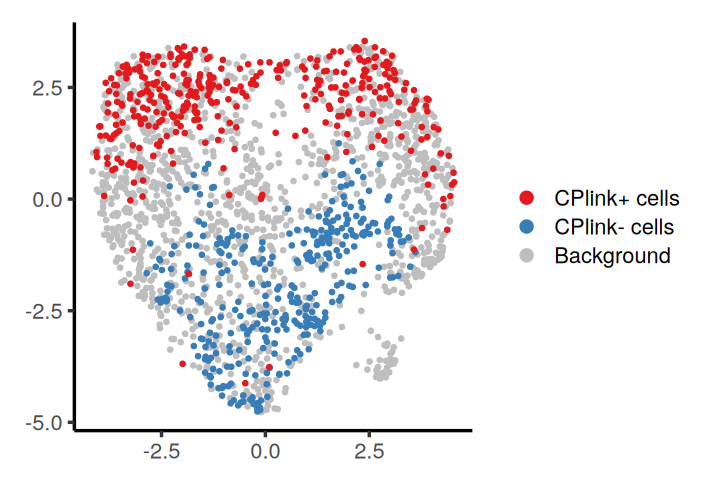

In [10]:
options(repr.plot.width=6, repr.plot.height=4)
DimPlot(sc_seurat,reduction="umap",group.by=c("cellLabels"), 
               #label = F, raster=FALSE,
       order=c("CPlink+ cells", "CPlink- cells", "Background"),
        cols = c("#e11a1d", "#387db8", "grey" ))+labs(title = NULL)+
scale_colour_discrete(breaks=c("CPlink+ cells", "CPlink- cells", "Background"), type= c("grey", "#387db8", "#e11a1d"))+
     theme_classic(base_size = 16, base_rect_size = 1.5)+
     theme(axis.title = element_blank(),
           plot.title = element_text( colour = "black"),
          legend.text = element_text( colour = "black")
          )

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


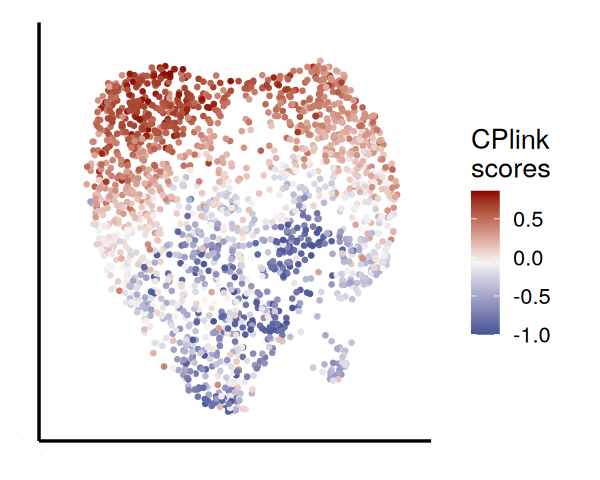

In [11]:
options(repr.plot.width=5, repr.plot.height=4)
FeaturePlot(sc_seurat,
            features = "CPlinkScore", raster=FALSE, label = FALSE) +
            scale_color_gradientn(colors = c("#475496", "#F5F5F5", "darkred"))+
labs(title = NULL)+
     theme_classic(base_size = 16, base_rect_size = 1.5)+
     theme(panel.grid = element_blank(), axis.ticks = element_blank(),legend.position = "right",
           panel.border = element_blank(),
           axis.text = element_blank(),
           axis.title = element_text(size = 0, hjust = 0, colour = "black"), 
           plot.title = element_text( hjust=0.5, colour = "black"),
          legend.text = element_text(colour = "black")
          ) +
  guides(color = guide_colorbar(title = "CPlink \nscores"))

In [12]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 22.10

Matrix products: default
BLAS/LAPACK: /home/server/anaconda3/envs/CPlinkTest/lib/libopenblasp-r0.3.27.so;  LAPACK version 3.12.0

locale:
 [1] LC_CTYPE=zh_CN.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=zh_CN.UTF-8        LC_COLLATE=zh_CN.UTF-8    
 [5] LC_MONETARY=zh_CN.UTF-8    LC_MESSAGES=zh_CN.UTF-8   
 [7] LC_PAPER=zh_CN.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=zh_CN.UTF-8 LC_IDENTIFICATION=C       

time zone: Asia/Shanghai
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] CelliD_1.10.1               SingleCellExperiment_1.22.0
 [3] CPlink_0.1.0                ggplot2_3.5.1              
 [5] Signac_1.13.0               harmony_0.1.1              
 [7] Rcpp_1.0.13              